In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dropout,Dense,Flatten, Reshape
from tensorflow.keras.models import Model
from keras.utils.data_utils import get_file
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
%matplotlib inline

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Downloading training and test sets to local drive
try:
    data_path_train = get_file('kddcup.data.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz')
except:
    print('Error downloading')
    raise

df = pd.read_csv(data_path_train, header=None)
print("Read {} rows into dataframe.".format(len(df)))

Read 4898431 rows into dataframe.


In [4]:
columns_tr = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

df.columns = columns_tr

In [5]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


<Figure size 432x288 with 0 Axes>

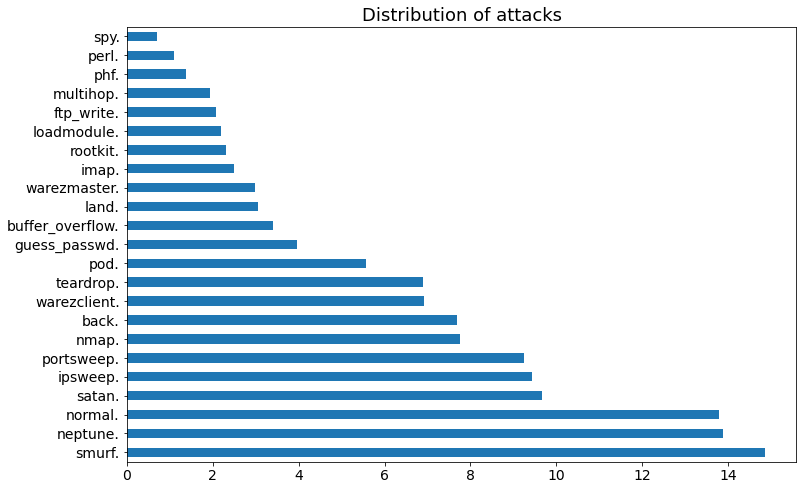

In [6]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
df['label'].value_counts().apply(np.log).plot(kind='barh')

plt.show()

In [7]:
def change_label(df):
  df.label.replace(['apache2.','back.','land.','neptune.','mailbomb.','pod.','processtable.','smurf.','teardrop.','udpstorm.','worm.'],'Dos',inplace=True)
  df.label.replace(['ftp_write.','guess_passwd.','httptunnel.','imap.','multihop.','named.','phf.','sendmail.',
       'snmpgetattack.','snmpguess.','spy.','warezclient.','warezmaster.','xlock.','xsnoop.'],'R2L',inplace=True)
  df.label.replace(['ipsweep.','mscan.','nmap.','portsweep.','saint.','satan.'],'Probe.',inplace=True)
  df.label.replace(['buffer_overflow.','loadmodule.','perl.','ps.','rootkit.','sqlattack.','xterm.'],'U2R',inplace=True)
  df.label.replace(['normal.'], 'Normal', inplace=True)
  df.label.replace(['Probe.'], 'Probe', inplace=True)

In [8]:
change_label(df)

<Figure size 432x288 with 0 Axes>

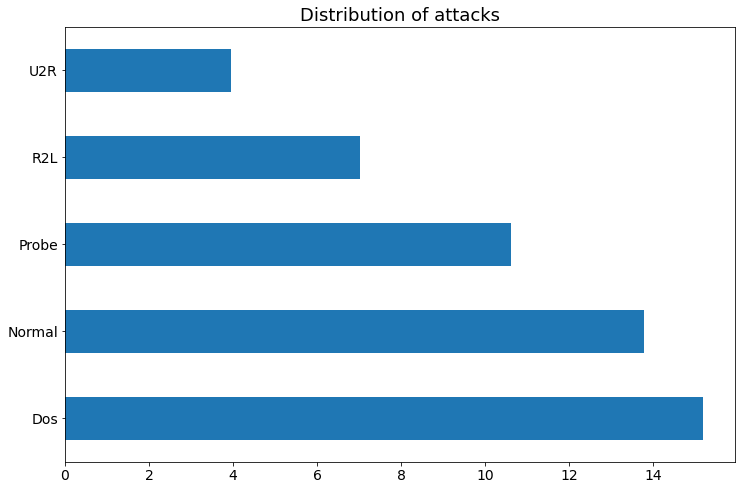

In [9]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
df['label'].value_counts().apply(np.log).plot(kind='barh')

plt.show()

In [10]:
df.label.value_counts()

Dos       3883370
Normal     972781
Probe       41102
R2L          1126
U2R            52
Name: label, dtype: int64

In [11]:
numeric_col = df.select_dtypes(include='number').columns

In [12]:
std_scaler = MinMaxScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

In [13]:
df = normalization(df.copy(),numeric_col)

In [14]:
# data after normalization
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,tcp,http,SF,1.558012e-07,3.441080e-05,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,Normal
1,0.0,tcp,http,SF,1.173944e-07,3.456654e-06,0.0,0.0,0.0,0.0,...,0.003922,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,Normal
2,0.0,tcp,http,SF,1.710190e-07,9.374494e-07,0.0,0.0,0.0,0.0,...,0.007843,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,Normal
3,0.0,tcp,http,SF,1.688450e-07,1.551219e-06,0.0,0.0,0.0,0.0,...,0.011765,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,Normal
4,0.0,tcp,http,SF,1.731929e-07,3.710101e-07,0.0,0.0,0.0,0.0,...,0.015686,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,Normal


In [15]:
# one-hot encode
cat_col = ['protocol_type','service','flag']

In [16]:
categorical = df[cat_col]

In [17]:
categorical = pd.get_dummies(categorical,columns=cat_col)
df = pd.concat([df,categorical],axis=1)

In [18]:
df.drop('protocol_type', axis=1, inplace=True)
df.drop('service', axis=1, inplace=True)
df.drop('flag', axis=1, inplace=True)

df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.558012e-07,3.441080e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1.173944e-07,3.456654e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1.710190e-07,9.374494e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,1.688450e-07,1.551219e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,1.731929e-07,3.710101e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 

In [20]:
df.shape

(4898431, 123)

In [21]:
data,labels=df,df.pop("label").values

train_data, test_data = train_test_split(
    data, test_size=0.3, random_state=23
)

In [22]:
train_labels, test_labels = train_test_split(
    labels, test_size=0.3, random_state=23
)

In [ ]:
train_data = train_data.values.reshape(train_data.shape[0], train_data.shape[1], -1)
test_data = test_data.values.reshape(test_data.shape[0], test_data.shape[1], -1)

In [ ]:
train_data.shape, test_data.shape

In [ ]:
train_labels.shape, test_labels.shape

In [ ]:
train_Y_one_hot = pd.get_dummies(train_labels.copy())
test_Y_one_hot = pd.get_dummies(test_labels.copy())

In [ ]:
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot.loc[0])

In [ ]:
input_shape = Input(shape = (train_data.shape[1], train_data.shape[2]))

def encoder(input_shape):
    #encoder
    noise_layer = tf.keras.layers.GaussianNoise(.3, seed=0)(input_shape)

    conv1 = layers.Conv1D(41, 3, activation='relu', padding='same')(noise_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(41, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)

    conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    conv3 = layers.Conv1D(16, 3, activation='relu', padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(16, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    conv4 = layers.Conv1D(8, 3, activation='relu', padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(8, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    return conv3

def decoder(conv4):    
    #decoder
    conv5 = layers.Conv1DTranspose(16, 3, activation='relu', padding='same')(conv4) 
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv1DTranspose(16, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv6 = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(conv5) 
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv7 = layers.Conv1DTranspose(41, 3, activation='relu', padding='same')(conv6) 
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv1DTranspose(41, 3, activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(conv7)
    return decoded

In [ ]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(5, activation='softmax')(den)
    return out

In [ ]:
encode = encoder(input_shape)
full_model = Model(input_shape, fc(encode))

dual_autoencoder = Model(input_shape, [fc(encode), decoder(encode)])
basic_autoencoder = Model(input_shape, decoder(encoder(input_shape)))

In [ ]:
lr = 0.05
batch_size = 128
ep = 25

In [ ]:
dual_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['accuracy']
)

In [ ]:
dual_autoencoder.summary()

In [ ]:
history = dual_autoencoder.fit(
    train_data,
    [np.zeros(train_labels.shape), train_data],
    epochs=ep,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

In [ ]:
dual_autoencoder.save('./drive/MyDrive/trained_models/autoencoder_denoise.h5') 
dual_autoencoder.save_weights('./drive/MyDrive/trained_models/autoencoder_denoise_weights.h5')

In [ ]:
autoencoder_classify = tf.keras.models.load_model('./drive/MyDrive/trained_models/autoencoder_denoise.h5')

In [ ]:
autoencoder_classify.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
classify_train = autoencoder_classify.fit(
    train_data, 
    [train_Y_one_hot, train_data], 
    batch_size=64,
    epochs=25,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

In [ ]:
autoencoder_classify.save('./drive/MyDrive/trained_models/autoencoder_classify.h5') 
autoencoder_classify.save_weights('./drive/MyDrive/trained_models/autoencoder_classify_weights.h5')

In [ ]:
autoencoder_classify = tf.keras.models.load_model('./drive/MyDrive/trained_models/autoencoder_classify.h5')

In [ ]:
tf.keras.utils.plot_model(autoencoder_classify, to_file='img.png', show_shapes=True)

In [ ]:
noise_layer = tf.keras.layers.Dropout(.3)
test_data_noised = noise_layer(test_data, training=True)

In [ ]:
test_eval = autoencoder_classify.evaluate(test_data_noised, [test_Y_one_hot, test_data], verbose=0)

In [ ]:
for metric_name, value in zip(autoencoder_classify.metrics_names, test_eval):
  print(metric_name + ":", value)

In [ ]:
predicted_classes = autoencoder_classify.predict(test_data_noised)[0]

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
tl = test_Y_one_hot.to_numpy()
tl = np.argmax(np.round(tl),axis=1)

In [ ]:
predicted_classes.shape, tl.shape

In [ ]:
tl[0:5]

In [ ]:
predicted_classes[0:5]

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(tl.astype(int), predicted_classes.astype(int), target_names=target_names))

In [ ]:
import seaborn as sns

In [ ]:
LABELS = ['DOS', 'Normal', 'Probe', 'R2L', 'U2R'] 
conf_matrix = confusion_matrix(tl.astype(int), predicted_classes.astype(int)) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [ ]:
# 